**Please select GPU to run this code. And the R code could a take a while, it is recommended to run it locally not on colab.**

In [ ]:
!git clone https://github.com/davidroad/BMI_7320_Final.git

Cloning into 'BMI_7320_Final'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 55 (delta 23), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (55/55), 790.36 KiB | 6.64 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [ ]:
!pwd

/content


In [ ]:
!mkdir -p /content/BMI_7320_Final/VEGA_PBMC/save_model
!mkdir -p /content/BMI_7320_Final/VEGA_PBMC/data
##download both h5ad and seurat object




In [ ]:
!gdown https://drive.google.com/uc?id=1fWKmDb_3NqjABWzrCU83x0WQMLgZBkkw -O /content/BMI_7320_Final/VEGA_PBMC/data/pbmc_IFN_filtered.Rdata
!gdown https://drive.google.com/uc?id=1Q0he0UJDX90tFxMhwRvf_wXScqh5Aa0V -O /content/BMI_7320_Final/VEGA_PBMC/data/pbmc_IFN_filtered.h5ad

Downloading...
From: https://drive.google.com/uc?id=1fWKmDb_3NqjABWzrCU83x0WQMLgZBkkw
To: /content/BMI_7320_Final/VEGA_PBMC/data/pbmc_IFN_filtered.Rdata
100% 41.8M/41.8M [00:00<00:00, 64.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Q0he0UJDX90tFxMhwRvf_wXScqh5Aa0V
To: /content/BMI_7320_Final/VEGA_PBMC/data/pbmc_IFN_filtered.h5ad
100% 56.4M/56.4M [00:01<00:00, 49.0MB/s]


In [ ]:
import sys
sys.path.insert(0,"/content/BMI_7320_Final/VEGA_PBMC/")

In [ ]:
 ! pip install scanpy
 ! pip install torch



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=539b1765f8c85063b227bd6fe0f2359c9a474106c263d5330d2baf2529c0e5cb
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=1f88e2d806d03c34ed66b85dd3229e463d8216b7723b59a0e6b1ac8076c3945d
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9

In [ ]:
import torch
from vega_model import VEGA
from utils import *
from learning_utils import *
import scanpy as sc
from scipy import sparse
from sklearn import preprocessing
import numpy as np
import itertools
import argparse
import os
import pandas as pd
import umap


In [ ]:
full_data = sc.read_h5ad("/content/BMI_7320_Final/VEGA_PBMC/data/pbmc_IFN_filtered.h5ad")

In [ ]:
print(full_data)


AnnData object with n_obs × n_vars = 13672 × 35635
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'label', 'tsne1', 'tsne2', 'ind', 'stim', 'clusters', 'cell.type', 'multiplets', 'percent.mt'
    var: 'features'


In [ ]:
full_data.obs['cell.type'].value_counts()

CD4 T cells          5089
CD14+ Monocytes      4183
FCGR3A+ Monocytes    1351
B cells              1324
NK cells              638
CD8 T cells           564
Dendritic cells       403
Megakaryocytes        120
Name: cell.type, dtype: int64

In [ ]:
full_data.obs['cell_type']=full_data.obs['cell.type']

In [ ]:
full_data.obs

,orig.ident,nCount_RNA,nFeature_RNA,label,tsne1,tsne2,ind,stim,clusters,cell.type,multiplets,percent.mt,cell_type
AAACATACATTTCC-1_1,SeuratProject,3018.0,878,control,-27.640373,14.966629,1016,ctrl,9,CD14+ Monocytes,singlet,0.099404,CD14+ Monocytes
AAACATACCAGAAA-1_1,SeuratProject,2481.0,713,control,-27.493646,28.924885,1256,ctrl,9,CD14+ Monocytes,singlet,0.241838,CD14+ Monocytes
AAACATACCTCGCT-1_1,SeuratProject,3420.0,850,control,-24.367997,20.429285,1256,ctrl,9,CD14+ Monocytes,singlet,0.087719,CD14+ Monocytes
AAACATACCTGGTA-1_1,SeuratProject,3158.0,1111,control,27.952170,24.159738,1039,ctrl,4,Dendritic cells,singlet,0.063331,Dendritic cells
AAACATACGATGAA-1_1,SeuratProject,1869.0,635,control,-0.470236,-25.398709,1488,ctrl,5,CD4 T cells,singlet,0.053505,CD4 T cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGAACGAA-1_2,SeuratProject,5578.0,1238,case,-2.421106,28.893534,1244,stim,8,CD14+ Monocytes,singlet,0.089638,CD14+ Monocytes
TTTGCATGACGTAC-1_2,SeuratProject,1364.0,536,case,18.747179,1.919201,1488,stim,6,CD4 T cells,singlet,0.439883,CD4 T cells
TTTGCATGCCTGTC-1_2,SeuratProject,2116.0,819,case,-11.563067,2.574095,1256,stim,4,B cells,singlet,0.047259,B cells
TTTGCATGCTAAGC-1_2,SeuratProject,1522.0,523,case,25.142392,6.603815,107,stim,6,CD4 T cells,singlet,0.000000,CD4 T cells


In [ ]:
full_data.X

<13672x35635 sparse matrix of type '<class 'numpy.float64'>'
	with 9530688 stored elements in Compressed Sparse Row format>

In [ ]:
pathway_path= '/content/BMI_7320_Final/VEGA_PBMC/pathway/'

In [ ]:
pathway_file_list=os.listdir(pathway_path)
pathway_file_list=[i for i in pathway_file_list if '.gmt' in i]

In [ ]:
pathway_file_list

['GO_merged_non_redundant_full_term_name_gene_symbol_rename.gmt',
 'h.all.v2023.1.Hs.symbols.gmt']

##choose Hallmark (h.all.v2023.1.Hs.symbols.gmt) first and then run GO

In [ ]:
pathway_file=pathway_file_list[1]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
import seaborn as sns


In [ ]:
# Set model
random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(dev)
LR = 1e-4
N_EPOCHS=20
p_drop = 0.5

dir_name='/content/BMI_7320_Final/VEGA_PBMC/save_model'


cuda


In [ ]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [ ]:
##leave 'CD8 T cells' out as an example
##https://github.com/LucasESBS/vega-reproducibility/blob/main/src/train_vega_ct_out_pbmc.py
device = torch.device('cuda')
cell_type = 'CD8 T cells' ##CD14+ Monocytes
print('Training model leaving out '+cell_type, flush=True)
prefix_model = 'vega_kang_pbmc_%s_out_'%( cell_type)
print(prefix_model)
prefix_out = '5CV_vega_kang_pbmc_%s_out_res.npy'%(cell_type)
print(prefix_out)
##remove CD8 T cells in stim condition
train_data = full_data.copy()[~((full_data.obs['cell_type'] == cell_type) )]
labels = train_data.obs['cell_type']
le = preprocessing.LabelEncoder()
le.fit(labels)
y = torch.Tensor(le.transform(labels))
pathway_dict = read_gmt(pathway_path+pathway_file, min_g=0, max_g=1000)
pathway_mask = create_pathway_mask(train_data.var.index.tolist(), pathway_dict, add_missing=1, fully_connected=True)
print(pathway_mask)
if sparse.issparse(train_data.X):
  train_ds = train_data.X.A
else:
  train_ds = train_data.X
train_ds = torch.Tensor(train_ds)
print(1)
print(train_ds.is_cuda)
train_ds = UnsupervisedDataset(train_ds, targets=y)

# Initialize CV
kfold = KFoldTorch(cv=5, n_epochs=N_EPOCHS, lr=LR, train_p=10, test_p=10, num_workers=0, save_all=True, save_best=False, path_dir=dir_name, model_prefix=prefix_model)
dict_params = {'pathway_mask':pathway_mask, 'beta':0.00005, 'dropout':p_drop, 'path_model':None, 'device':dev, 'positive_decoder':True}
kfold.train_kfold(VEGA, dict_params, train_ds, batch_size=64)
np.save(dir_name+prefix_out, kfold.cv_res_dict)
print('Finished training for %s out'%(cell_type), flush=True)

Training model leaving out CD8 T cells
vega_kang_pbmc_CD8 T cells_out_
5CV_vega_kang_pbmc_CD8 T cells_out_res.npy
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
1
False
Model(s) will be saved at /content/BMI_7320_Final/VEGA_PBMC/save_model/ using vega_kang_pbmc_CD8 T cells_out_ as prefix
0.5
Constraining decoder to positive weights
cuda
Training fold 0
[Epoch 1] | loss: 133517.677 | test_loss: 132041.033 |
[Epoch 2] | loss: 132003.300 | test_loss: 130686.092 |
[Epoch 3] | loss: 130098.155 | test_loss: 127622.295 |
[Epoch 4] | loss: 127040.607 | test_loss: 123740.927 |
[Epoch 5] | loss: 123289.023 | test_loss: 117862.197 |
[Epoch 6] | loss: 119114.241 | test_loss: 113676.797 |
[Epoch 7] | loss: 114841.786 | test_loss: 108737.905 |
[Epoch 8] | loss: 110303.632 | test_loss: 102240.203 |
[Epoch 9] | loss: 105964.796 | test_loss: 98167.006 |
[Epoch 10] | loss: 100914.594 | test_loss:

In [ ]:
~((full_data.obs['cell_type'] == cell_type) ).value_counts()

False   -13109
True      -565
Name: cell_type, dtype: int64

In [ ]:
train_data.obs['cell.type'].unique()

array(['CD14+ Monocytes', 'Dendritic cells', 'CD4 T cells',
       'Megakaryocytes', 'B cells', 'FCGR3A+ Monocytes', 'NK cells'],
      dtype=object)

In [ ]:
##load the best model
device = torch.device('cpu')
model = VEGA(pathway_mask, positive_decoder=True,device =torch.device('cpu'))
# Load the best trained model weights
model.load_state_dict(torch.load('/content/BMI_7320_Final/VEGA_PBMC/save_model/vega_kang_pbmc_CD8 T cells_out_fold_4.pt',map_location=device))
model.to(device)
# Set the model to evaluation mode
model.eval()


0.2
Constraining decoder to positive weights


VEGA(
  (encoder): Sequential(
    (0): Linear(in_features=35635, out_features=800, bias=True)
    (1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=800, out_features=800, bias=True)
    (5): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
  )
  (mean): Sequential(
    (0): Linear(in_features=800, out_features=51, bias=True)
    (1): Dropout(p=0.2, inplace=False)
  )
  (logvar): Sequential(
    (0): Linear(in_features=800, out_features=51, bias=True)
    (1): Dropout(p=0.2, inplace=False)
  )
  (decoder): CustomizedLinear(input_features=51, output_features=35635, bias=True)
)

In [ ]:
next(model.parameters()).is_cuda

False

In [ ]:
n = 1
pathway_list = list(pathway_dict.keys())+['UNANNOTATED_'+str(k) for k in range(n)]
print(pathway_list)

['HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_HYPOXIA', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_MITOTIC_SPINDLE', 'HALLMARK_WNT_BETA_CATENIN_SIGNALING', 'HALLMARK_TGF_BETA_SIGNALING', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_DNA_REPAIR', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_APOPTOSIS', 'HALLMARK_NOTCH_SIGNALING', 'HALLMARK_ADIPOGENESIS', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_MYOGENESIS', 'HALLMARK_PROTEIN_SECRETION', 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_COMPLEMENT', 'HALLMARK_UNFOLDED_PROTEIN_RESPONSE', 'HALLMARK_PI3K_AKT_MTOR_SIGNALING', 'HALLMARK_MTORC1_SIGNALING', 'HALLMARK_E2F_TARGETS', 'HALLMARK_MYC_TARGETS_V1', 'HALLMARK_MYC_TARGETS_V2', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_XENOBIOTIC_METABOLISM', 'HALLMARK_FATT

In [ ]:
z = model.to_latent(torch.Tensor(train_data.X.A)).detach().numpy()
pathway_encoded_df = pd.DataFrame(data=z, index=train_data.obs.index.tolist(), columns=pathway_list)


In [ ]:
pathway_encoded_df

,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_HYPOXIA,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_MITOTIC_SPINDLE,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_IL6_JAK_STAT3_SIGNALING,HALLMARK_DNA_REPAIR,HALLMARK_G2M_CHECKPOINT,HALLMARK_APOPTOSIS,...,HALLMARK_COAGULATION,HALLMARK_IL2_STAT5_SIGNALING,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_PEROXISOME,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_SPERMATOGENESIS,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_PANCREAS_BETA_CELLS,UNANNOTATED_0
AAACATACATTTCC-1_1,3.099784,9.526872,23.477573,2.819548,-0.970742,2.432814,-11.002474,6.904285,-0.035956,6.577850,...,27.114857,-9.578570,-0.524274,7.805040,31.906925,-1.290477,-5.474119,-0.979218,2.540418,257.667206
AAACATACCAGAAA-1_1,0.907938,9.235347,23.015320,3.087185,-1.088835,3.349008,-12.613821,6.597537,0.242503,7.159516,...,29.525192,-10.680247,-0.632121,8.395329,35.975559,-1.423960,-6.648868,-1.857386,2.522187,265.040680
AAACATACCTCGCT-1_1,5.264965,13.343695,34.159138,3.937368,-0.826499,1.252316,-18.120073,10.019864,-0.801326,5.862610,...,34.730206,-16.743994,-0.509162,10.908459,39.648865,-2.141169,-10.457803,-1.777257,2.958612,397.390594
AAACATACCTGGTA-1_1,-9.715431,4.304408,9.002404,2.083516,0.245880,2.723628,-14.620148,2.740957,1.686967,2.442675,...,13.225034,-11.331429,0.912501,4.993977,37.206024,0.311185,-10.359865,-2.762985,2.777725,129.382187
AAACATACGATGAA-1_1,-19.984800,2.918197,4.439072,2.799034,1.198197,4.264128,-20.963253,1.089414,3.213688,1.254701,...,11.162545,-15.771805,2.149637,6.244940,56.568756,1.566440,-15.753598,-5.011784,3.409222,113.295288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGAACGAA-1_2,101.875778,14.210412,47.240269,5.029943,-2.863908,6.071378,108.165169,16.456558,13.155789,25.460558,...,-1.446246,99.392654,-1.767337,11.089198,59.764122,-1.942718,98.411293,33.215458,5.880474,203.625351
TTTGCATGACGTAC-1_2,-4.480147,0.526187,1.041679,1.052115,1.281650,1.990095,-2.774282,0.554619,3.366043,1.219044,...,-1.222103,-0.343939,1.846253,3.323638,34.084110,1.284371,-1.540339,-0.121549,2.442091,37.928551
TTTGCATGCCTGTC-1_2,-4.936364,1.280034,2.255219,2.119896,1.879831,2.709531,-1.609623,0.688414,4.513290,1.350175,...,-1.304877,0.620465,2.147821,4.411776,46.650536,1.311125,-0.524349,1.199022,3.130483,51.394016
TTTGCATGCTAAGC-1_2,-5.785851,1.029042,0.415214,1.054037,0.962893,1.668193,-4.481303,0.234271,2.536036,-0.075959,...,-0.077603,-3.017831,1.175905,3.284895,29.451754,0.907343,-3.320926,-0.938283,1.874109,35.866798


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


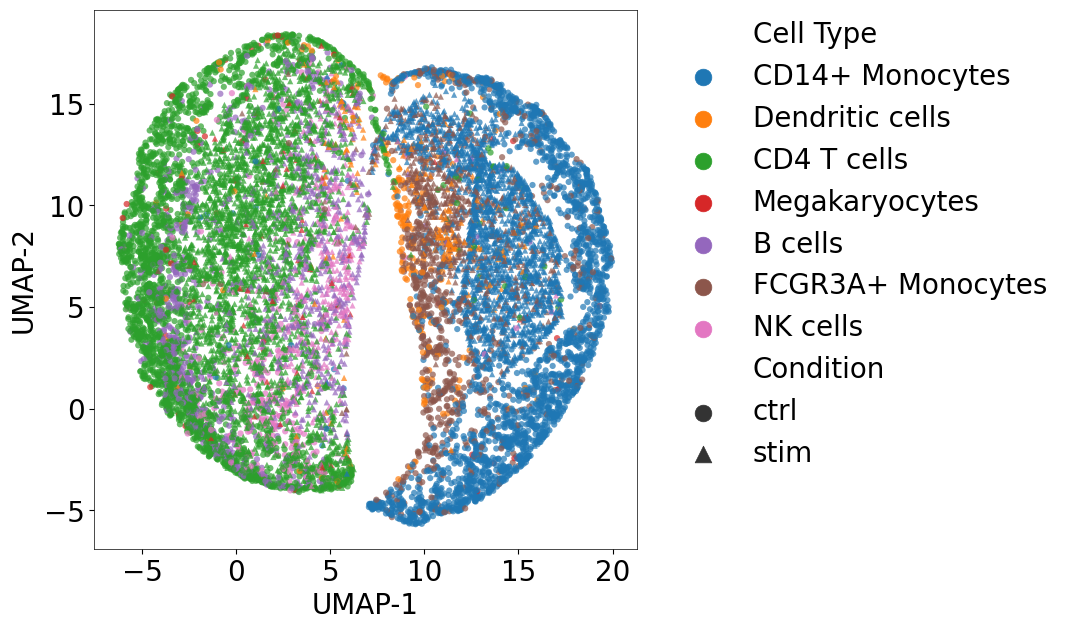

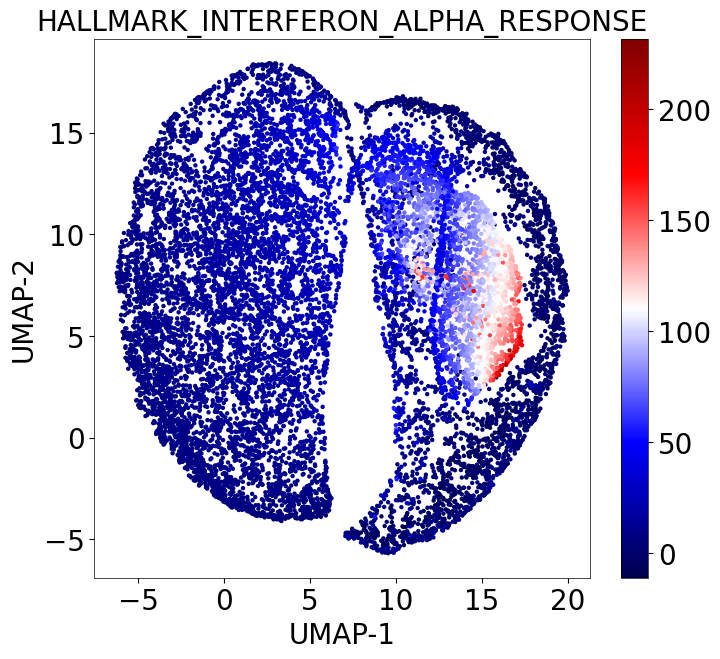

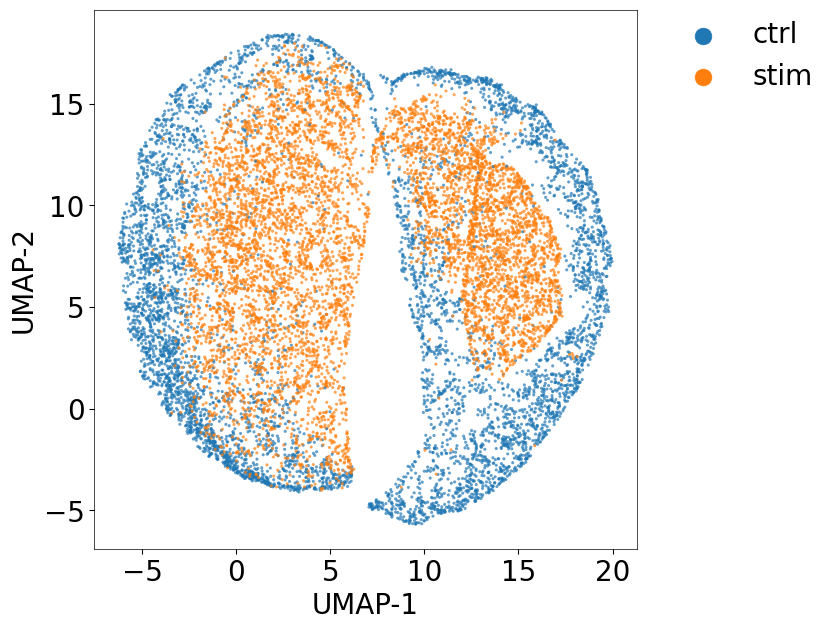

In [ ]:
reducer = umap.UMAP(random_state=42, min_dist=0.5, n_neighbors=15)
embedding = reducer.fit_transform(z)
umap_df = pd.DataFrame({'UMAP-1':embedding[:,0], 'UMAP-2':embedding[:,1],
                        'Cell Type':train_data.obs['cell_type'], 'Condition':train_data.obs['stim']})
plt.figure(figsize=[7,7])
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Cell Type', data=umap_df, style='Condition', markers=['o','^'],
                linewidth=0, alpha=0.7, s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
#plt.legend(frameon=False, ncol=1, fontsize=13, markerscale=1.5)
plt.xlabel('UMAP-1', fontsize=20)
plt.ylabel('UMAP-2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.figure(figsize=[8,7])
plt.scatter(embedding[:,0], embedding[:,1], alpha = 1, linewidths=0,
            c = pathway_encoded_df['HALLMARK_INTERFERON_ALPHA_RESPONSE'], marker='o', s=10, cmap = 'seismic')
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
plt.title('HALLMARK_INTERFERON_ALPHA_RESPONSE', fontsize=20)
plt.xlabel('UMAP-1', fontsize=20)
plt.ylabel('UMAP-2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig('../paper/figures/fig1-ifn-umap-deep.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


plt.figure(figsize=[7,7])
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Condition', data=umap_df,
                linewidth=0, alpha=0.7, s=5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
plt.xlabel('UMAP-1', fontsize=20)
plt.ylabel('UMAP-2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('../paper/figures/fig1-b-deep.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

**Q1 please reproduce the code on GO_merged_non_redundant_full_term_name_gene_symbol_rename.gmt with CD14+ Monocytes cells out and keep all the cells**.

In [ ]:
full_data.obs['cell.type'].value_counts()

CD4 T cells          5089
CD14+ Monocytes      4183
FCGR3A+ Monocytes    1351
B cells              1324
NK cells              638
CD8 T cells           564
Dendritic cells       403
Megakaryocytes        120
Name: cell.type, dtype: int64

**Q2 run through these R code on Rstudio with preinstalled library**

In [ ]:
##load R code for ssGSEA, following the tutorial https://bioconductor.org/packages/devel/bioc/vignettes/escape/inst/doc/vignette.html
%load_ext rpy2.ipython

In [ ]:
##install ssGSEA pacakge
%%R

install.packages("Seurat")
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("escape")
BiocManager::install("dittoSeq")

suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(escape))
suppressPackageStartupMessages(library(dittoSeq))

(as ‘lib’ is unspecified)




























































































































































































































































































































































































In [ ]:
##load TP
%%R
GO_non_redundant <- read.gmt("/content/BMI_7320_Final/VEGA_PBMC/pathway/GO_merged_non_redundant_full_term_name_gene_symbol_rename.gmt")
hall_mark <- read.gmt("/content/BMI_7320_Final/VEGA_PBMC/pathway/h.all.v2023.1.Hs.symbols.gmt")

#convert to certain type
GO_non_redundant_unique_TP = as.vector(unique(GO_non_redundant[,1]))
GO_non_redundant_gene_sets = list()
for(i in 1:length(GO_non_redundant_unique_TP)) {
	GO_non_redundant_gene_sets = c(GO_non_redundant_gene_sets,list(GO_non_redundant[which(GO_non_redundant[,1]==GO_non_redundant_unique_TP[i]),2]))
}
names(GO_non_redundant_gene_sets) = GO_non_redundant_unique_TP

hall_mark_unique_TP = as.vector(unique(hall_mark[,1]))
hall_mark_gene_sets = list()
for(i in 1:length(hall_mark_unique_TP)) {
	hall_mark_gene_sets = c(hall_mark_gene_sets,list(hall_mark[which(hall_mark[,1]==hall_mark_unique_TP[i]),2]))
}
names(hall_mark_gene_sets) = hall_mark_unique_TP

  could not find function "read.gmt"




Error in read.gmt("/content/BMI_7320_Final/VEGA_PBMC/pathway/GO_merged_non_redundant_full_term_name_gene_symbol_rename.gmt") : 
  could not find function "read.gmt"


In [ ]:
##load object
%%R

load("/content/BMI_7320_Final/VEGA_PBMC/data/pbmc_IFN_filtered.Rdata")
seurat_object_merged_filtered = subset(seurat_object_merged_filtered, subset=cell.type == "CD8 T cells" )


In [ ]:
##ssgsea
hall_mark.ES.seurat <- enrichIt(obj = Homo.combined_regressed,
                      gene.sets = hall_mark_gene_sets,
                      groups = 1000, cores = 6)

GO_non_redundant.ES.seurat <- enrichIt(obj = Homo.combined_regressed,
                      gene.sets = GO_non_redundant_gene_sets,
                      groups = 1000, cores = 6)

In [ ]:
##visualize the heatmap
%%R

GO_non_redundant.ES.seurat_filter = GO_non_redundant.ES.seurat[,grep("interferon",colnames(GO_non_redundant.ES.seurat))]
p <- dittoHeatmap(seurat_object_merged_filtered, genes = NULL, metas = names(GO_non_redundant.ES.seurat_filter),
             annot.by = "stim",
             fontsize = 7,
             cluster_cols = TRUE)
print(p)

